# Matrix Factorization

In [1]:
# loading data
from surprise import Dataset

# Load the movielens-100k dataset
data = Dataset.load_builtin("ml-100k")

# Retrieve the trainset.
trainset = data.build_full_trainset()

Apply Singular Value Decomposition ([SVD wiki](https://en.wikipedia.org/wiki/Singular_value_decomposition), [SVD Surprise](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)) to predict movie ratings. Particularly, apply standard SVD and Non-negative Matrix Factorization.
Which parameters are there?
Which ones should be tuned and adapted to the dataset?

In [2]:
from surprise import SVD, NMF
from surprise.model_selection import cross_validate

# Use SVD algorithm.
svd = SVD()

# Run 5-fold cross-validation and print results.
k_folds = 5
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=k_folds, verbose=True)

# Non-negative Matrix Factorization
nmf = NMF()

# Run 5-fold cross-validation and print results.
cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=k_folds, verbose=True)



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9364  0.9317  0.9334  0.9331  0.9378  0.9345  0.0023  
MAE (testset)     0.7371  0.7342  0.7351  0.7330  0.7405  0.7360  0.0026  
Fit time          1.15    1.19    1.22    1.21    1.55    1.27    0.14    
Test time         0.19    0.21    0.17    0.19    0.22    0.20    0.02    
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9631  0.9637  0.9633  0.9714  0.9581  0.9639  0.0043  
MAE (testset)     0.7584  0.7555  0.7552  0.7623  0.7555  0.7574  0.0027  
Fit time          3.08    2.92    3.24    2.04    1.96    2.65    0.54    
Test time         0.18    0.37    0.28    0.17    0.19    0.24    0.08    


{'test_rmse': array([0.96312141, 0.9637036 , 0.96326604, 0.9713906 , 0.95809842]),
 'test_mae': array([0.75839028, 0.75545817, 0.75522525, 0.76229513, 0.75551782]),
 'fit_time': (3.0789947509765625,
  2.923823833465576,
  3.2359890937805176,
  2.041125535964966,
  1.9648725986480713),
 'test_time': (0.17754316329956055,
  0.37223100662231445,
  0.2762930393218994,
  0.16778087615966797,
  0.19307279586791992)}

**1. Singular Value Decomposition (SVD):**

In the context of the Surprise library, the main parameters of the SVD algorithm include:

- `n_factors`: The number of latent factors. Default is 100.
- `n_epochs`: The number of iterations of the SGD procedure. Default is 20.
- `lr_all`: The learning rate for all parameters. Default is 0.005.
- `reg_all`: The regularization term for all parameters. Default is 0.02.

Parameters to consider tuning:

- `n_factors`: Represents the number of latent factors. Depending on your data, increasing or decreasing this value can have an impact on your results. 
- `lr_all`: Controls the learning rate for all parameters, affecting the speed at which your model learns. 
- `reg_all`: Controls the regularization term for all parameters, affecting the model's generalization capability. 

**2. Non-negative Matrix Factorization (NMF):**

In the context of the Surprise library, the main parameters of the NMF algorithm include:

- `n_factors`: The number of latent factors. Default is 15.
- `n_epochs`: The number of iterations of the SGD procedure. Default is 50.
- `reg_pu`: The regularization term for users. Default is 0.06.
- `reg_qi`: The regularization term for items. Default is 0.06.

Parameters to consider tuning:

- `n_factors`: Represents the number of latent factors. Depending on your data, increasing or decreasing this value can have an impact on your results.
- `reg_pu` and `reg_qi`: These parameters control the regularization term for users and items respectively, affecting the model's generalization capability.

In [3]:
from surprise import SVD, NMF, Dataset
from surprise.model_selection import GridSearchCV

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

# Define the parameter grid for SVD
param_grid_svd = {
    'n_factors': [50, 100, 150], 
    'n_epochs': [20, 30], 
    'lr_all': [0.005, 0.01], 
    'reg_all': [0.02, 0.1]
}

# Use grid search to find optimal parameters for SVD
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=5)
gs_svd.fit(data)

# Print optimal parameters for SVD
print("Best parameters for SVD: ", gs_svd.best_params['rmse'])

# Define the parameter grid for NMF
param_grid_nmf = {
    'n_factors': [10, 15, 20], 
    'n_epochs': [50, 70], 
    'reg_pu': [0.06, 0.1], 
    'reg_qi': [0.06, 0.1]
}

# Use grid search to find optimal parameters for NMF
gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mae'], cv=5)
gs_nmf.fit(data)

# Print optimal parameters for NMF
print("Best parameters for NMF: ", gs_nmf.best_params['rmse'])


Best parameters for SVD:  {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}
Best parameters for NMF:  {'n_factors': 20, 'n_epochs': 70, 'reg_pu': 0.1, 'reg_qi': 0.1}


<h2>K-Fold Evaluation</h2>

Evaluate the matrix factorization approaches in a k-fold cross-evaluation scenario and compute error metrics as well as recall, precision, and F1. Discuss the results and possible explanations for the differences.

In [4]:
from surprise import SVD, NMF, Dataset, accuracy
from surprise.model_selection import KFold
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [5]:
# get best params for both
best_params_svd = gs_svd.best_params['rmse']
best_params_nmf = gs_nmf.best_params['rmse']

# create algorithms with best params
svd = SVD(**best_params_svd)
nmf = NMF(**best_params_nmf)

# K-Fold cross-validation
kf = KFold(n_splits=5)

algo_metrics = {
    "SVD": {"precision": [], "recall": [], "f1": []},
    "NMF": {"precision": [], "recall": [], "f1": []}
}

for algo in (svd, nmf):
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

        # Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        f1 = 2 * (precision * recall) / (precision + recall)

        algo_name = str(algo).split(" ")[0].split(".")[-1]
        algo_metrics[algo_name]["precision"].append(precision)
        algo_metrics[algo_name]["recall"].append(recall)
        algo_metrics[algo_name]["f1"].append(f1)

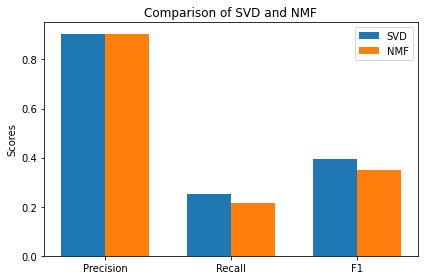

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting
x = np.arange(3)
width = 0.35  # width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [np.mean(algo_metrics["SVD"]["precision"]), np.mean(algo_metrics["SVD"]["recall"]), np.mean(algo_metrics["SVD"]["f1"])], width, label='SVD')
rects2 = ax.bar(x + width/2, [np.mean(algo_metrics["NMF"]["precision"]), np.mean(algo_metrics["NMF"]["recall"]), np.mean(algo_metrics["NMF"]["f1"])], width, label='NMF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of SVD and NMF')
ax.set_xticks(x)
ax.set_xticklabels(['Precision', 'Recall', 'F1'])
ax.legend()

fig.tight_layout()

plt.show()

Discussion [TODO]

<h2>Visualization</h2>

Visualize the resulting lower-dimensional user and item representations (embeddings) to get a deeper understanding of the results. Think about how you could visualize users and items in a common space that allows to investigate the similarity of e.g., user A to a set of potential movie recommendation candidates. Note that this exercise is formulated rather loosely on purpose to let you be creative and play with the data obtained.

## t-SNE

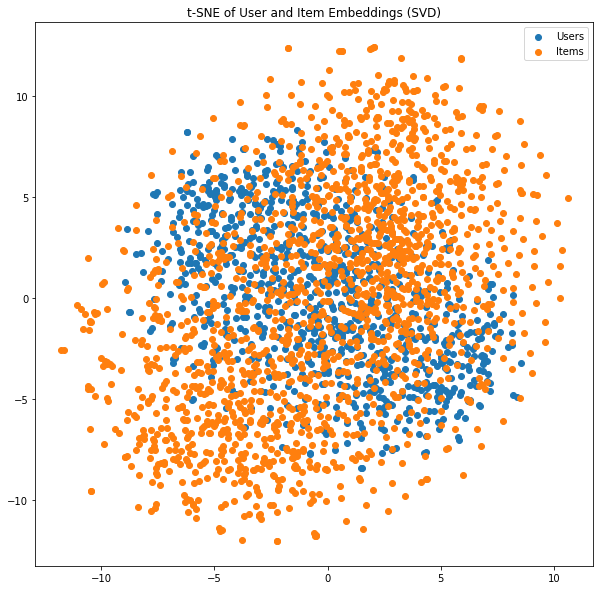

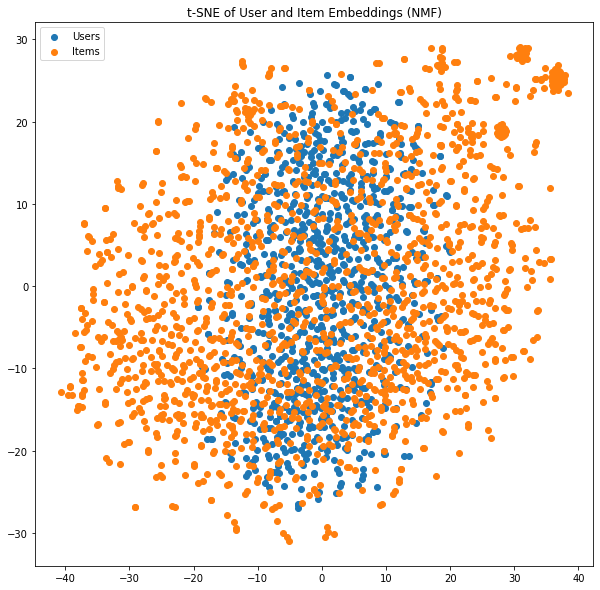

In [7]:
# code
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# fit the models first
svd.fit(data.build_full_trainset())
nmf.fit(data.build_full_trainset())

# get the user and item embeddings from the fitted models
user_embeddings_svd = svd.pu
item_embeddings_svd = svd.qi
user_embeddings_nmf = nmf.pu
item_embeddings_nmf = nmf.qi

# create a TSNE instance
tsne = TSNE(n_components=2, random_state=42)

# apply t-SNE to the embeddings
user_embeddings_svd_2d = tsne.fit_transform(user_embeddings_svd)
item_embeddings_svd_2d = tsne.fit_transform(item_embeddings_svd)
user_embeddings_nmf_2d = tsne.fit_transform(user_embeddings_nmf)
item_embeddings_nmf_2d = tsne.fit_transform(item_embeddings_nmf)

# plot the transformed user and item embeddings for SVD
plt.figure(figsize=(10, 10))
plt.scatter(user_embeddings_svd_2d[:, 0], user_embeddings_svd_2d[:, 1], label='Users')
plt.scatter(item_embeddings_svd_2d[:, 0], item_embeddings_svd_2d[:, 1], label='Items')
plt.title('t-SNE of User and Item Embeddings (SVD)')
plt.legend()
plt.show()

# plot the transformed user and item embeddings for NMF
plt.figure(figsize=(10, 10))
plt.scatter(user_embeddings_nmf_2d[:, 0], user_embeddings_nmf_2d[:, 1], label='Users')
plt.scatter(item_embeddings_nmf_2d[:, 0], item_embeddings_nmf_2d[:, 1], label='Items')
plt.title('t-SNE of User and Item Embeddings (NMF)')
plt.legend()
plt.show()


## PCA

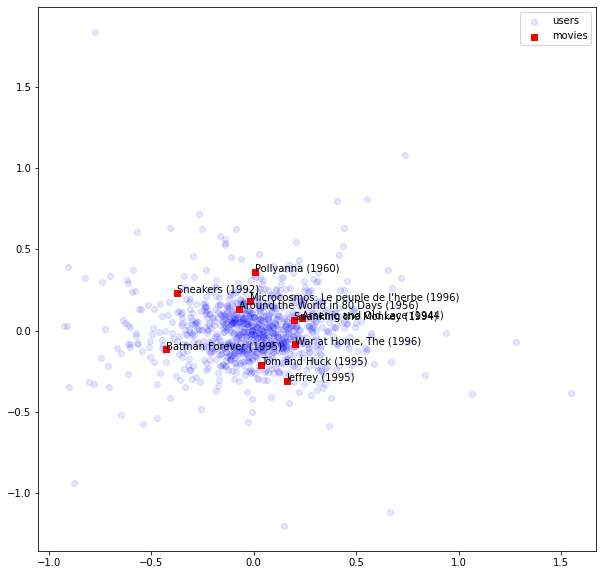

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import random
import os

# Load the movielens-100k dataset
data = Dataset.load_builtin("ml-100k")

# Fit SVD model on the data
trainset = data.build_full_trainset()
svd = SVD(n_factors=20, random_state=0)
svd.fit(trainset)

# Get ids to inner ids mappings
trainset_iid_to_raw = trainset._raw2inner_id_items
trainset_uid_to_raw = trainset._raw2inner_id_users

# Pick 100 random users and 10 random items
#random_users = random.sample(list(trainset_uid_to_raw.keys()), 100)
#use all users
random_users = trainset_uid_to_raw.keys()
random_items = random.sample(list(trainset_iid_to_raw.keys()), 10)

user_embeddings = np.array([svd.pu[trainset.to_inner_uid(uid)] for uid in random_users])
item_embeddings = np.array([svd.qi[trainset.to_inner_iid(iid)] for iid in random_items])

# Reduce dimension to 2 using PCA
pca = PCA(n_components=2)
user_embeddings_pca = pca.fit_transform(user_embeddings)
item_embeddings_pca = pca.transform(item_embeddings)

# Get the path to the movie titles file
file_path = os.path.expanduser('~/.surprise_data/ml-100k/ml-100k/u.item')

# Create a dictionary to store the movie id to name mapping
id_to_name = {}

# Load the movie names
with open(file_path, 'r', encoding='ISO-8859-1') as f:
    for line in f:
        line = line.split('|')
        movie_id = line[0]
        movie_name = line[1]
        id_to_name[movie_id] = movie_name

# Plotting
plt.figure(figsize=(10, 10))

# Plot users
plt.scatter(user_embeddings_pca[:, 0], user_embeddings_pca[:, 1], marker='o', color='b', alpha=0.1, label='users')

# Plot items
plt.scatter(item_embeddings_pca[:, 0], item_embeddings_pca[:, 1], marker='s', color='r', label='movies')
for i, iid in enumerate(random_items):
    movie_name = id_to_name.get(iid, iid)  # get the movie name if it exists in the mapping, else use the id
    plt.annotate(movie_name, (item_embeddings_pca[i, 0], item_embeddings_pca[i, 1]))

plt.legend()
plt.show()
